# Reading Handwritten Digits using Classification

This project will be using the MNIST dataset, which comprises over 70,000 small images of handwritten digits. 

The MNIST is one of the most popular datasets. It is thus available on Scikit learn. 

The following code shows fetching the dataset.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784",version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Data on sci-kit learn will contain 
<ul>
<li>A descr key describing the dataset</li>
<li>A data key containing an array with one row per instance and one column per feature.
<li>A target key containing an array with labels</li>
</ul>

In [5]:
X,y = mnist["data"], mnist["target"]

print(X.shape,y.shape)

(70000, 784) (70000,)


The above cell shows the dataset has 70,000 instances, and each instance has 784 features. Why 784?

Each image has 28 by 28 pixels, which is equal to 784. Each feature is the intensity of a dataset.

To create an image, you have to grab the instance's feature vector, reshape it into a 28 by 28 arraym and display it using the matplotlib's <code>imshow()</code> function.

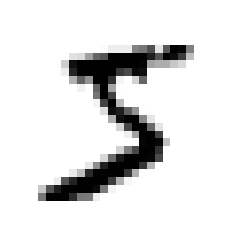

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

a_digit = X.iloc[0]

#reshape is called on the values attribute to retain the shape of the original series object.
a_digit_image = a_digit.values.reshape(28,28)

plt.imshow(a_digit_image,cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()


In [28]:
y[0]

'5'

The image shown above looks like a 5. Indeed, looking at the label, we see that it is 5. Well then!

The label is a string, and we would like to work with integers. We thus cast it into an int.

In [29]:
import numpy as np


y = y.astype(np.uint8)

That was a general look. Remember we have to split the dataset into train and test sets before we begin looking closely into the data. 

In [30]:

#the first 60k instances are for training while the last 10k are for testing

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<strong>The dataset has already been shuffled. Thus, we are assured the cross validation sets will have one of every digit.</strong>

## Binary classification.

First, let us identify a single digit. We want to see if we can successfully discriminate 5 from other digits.

Thus, there will be two classes:

Five, and not five

In [31]:
y_train_5 = (y_train == 5)

y_test_5 = (y_test == 5)

Next, we pick a classifier and train it. 

We first start with the <i>Schochastic Gradient Descent</i> classfier, which can be accessed using scikit learn's <code>SGDClassier</code>

The classifier can handle large dataset efficiently because it deals with training instances indipendently, one at a time. 

In [34]:
from sklearn.linear_model import SGDClassifier

sgd_cl = SGDClassifier(random_state=42) #we set the random state so that we can have reproducible results

sgd_cl.fit(X_train.values,y_train_5)#use the array of values on the fit function rather than the pahdas dataframe. else you get a warning.

SGDClassifier(random_state=42)

Let us see whether it can predict the number 5

In [35]:
sgd_cl.predict([a_digit.values])#use the array of values dont provide column names. 

array([ True])

The model has correctly guessed that the digit represents a 5.

## Performance Measures

Evaluating a classifier is significantly trickier than evaluating a regressor. 

### Measuring Accuracy using Cross-Validation

Let us use the <code>cross_val_score()</code> to evaluate the <code>SGDClassifier</code> using K-fold cross vlidation with 3 folds.

In [36]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_cl,X_train.values,y_train_5.values,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The models display a high accuracy. However, there is a small problem. since the true values are a small set of total dataset, then predicting not true will give us a higher accuracy even if the model is not predicting 5's correctly. 

### Confusion Matrix

The general idea of a confusion matrix is to count the number of times instances of class 'A' are classified as class 'B'. eg o know the nmber of times the classiier confused 5 with 3, look in the fifth row and 3rd column.

To compute the confusion matrix, you first need a set of predictions, so they can be coompared to the actual target. 

You can do that using the <code>cross_val_predict()</code> function.

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_cl,X_train.values,y_train_5.values,cv=3)

Just like the <code>cross_val_score()</code> function, the <code>cross_val_predict()</code> function evaluates predictions with Kfold CV. 

However, the method does not return scores. rather, it returns the predictions made by the model for each instance. 

To get the confusion matrix, import the <code>confusion_matrix()</code> function, and pass it the target classes and the predicted classes.

In [39]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents a class, while the column represents a predicted class. 

The first row of this matrix considers non-5 image (negative), where 54k were correct. These are called true negatives. On the other hand, 687 of the numbers were wrongly classified as 5. These are the false positive. 

The second row consider the 5 images. (positive). There were 1900 5s that were classified as non five (false negative), while 3500 were correctly classified as  5 (true positive)


Thus, a perfect classifier has only true positives and true negatives with the other values as zero.

Presicion is the accuracy of true positive predictions

Recall is the ratio of true positive to all positive instances.





### Precision and Recall

Scikit learn provides several functions to compute classifier metrics. These also include precision and recall. 

In [45]:
from sklearn.metrics import precision_score, recall_score


print(f"Precision: {precision_score(y_train_5,y_train_pred)} \nRecall: {recall_score(y_train_5,y_train_pred)}")

Precision: 0.8370879772350012 
Recall: 0.6511713705958311


When the model positively identifies a 5, it is 83 % correct. Also, it only detects 65% of the fives in the dataset.

It is often convinient to comobine precision and recall into a single metric called the F1 score. F1 score is the harmonic mean of precision and recall. 

In [50]:
from sklearn.metrics import f1_score

f1s = f1_score(y_train_5,y_train_pred)

print(f"F1 Score:{f1s}")

F1 Score:0.7325171197343846


One problem with F1 score is that it likes when precision and recall are close together. However, these might not be the case for all classifiers.

Sometimes, we may want classifiers that have a high precision, even if it means low recall. eg a safe content for minors in a video platform.

at other times, we may want a classifier with a high recall rate, even if it means low precision eg an ai to catch shoplifers.

However, it is impossible to have a model with very high precision, and also high recall. There must be a tradeoff. 



#### Precision recall tradeoff

To understand the tradeoff, let us consider how the <code>SGDClassifier </code> classifier works. 

The classifier computes a score based on a decision function. If that score is greater than the a threshold, then the instance is positive.

otherwise, the score is negative. 

You will see that raising the threshold, (moving it to the right) will increase precision but reduce recall.

However, lowering the threshold, (moving it to the left) will decrease the precision but increase the recall.

In scikit learn, you cannot set the threshold.

However, you can access the <code>desicion_function()</code> which returns a score for each instance, and can make predictions based on those scores using the threshold you want

In [54]:
y_score = sgd_cl.decision_function([a_digit])

y_score

threshold = 0 #the default threshold for the SGDC classifier is usually 0

y_some_digit_pred = (y_score > threshold)

y_some_digit_pred

array([ True])

We can also try to raise the threshold to 8k

In [55]:
threshold = 8000

y_some_digit_pred = (y_score > threshold)

y_some_digit_pred

array([False])

We have raised the threshold, such that the model considers the 5 to be something else (false negative): reduced recall.

To decide which threshold to use, you should get the scores of all instances in the training set using the <code>cross_val_predict()</code>

However, instead specify that you want to return decision scores instread of predictions.

In [56]:
y_scores = cross_val_predict(sgd_cl,X_train.values,y_train_5,cv=3,method='decision_function')

Now, using the scores, we can compute precision and recall for all possible thresholds using the <code>precision_recall_curve()</code> function.

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5.values,y_scores)

Finally, we plot the functions using matplotlib

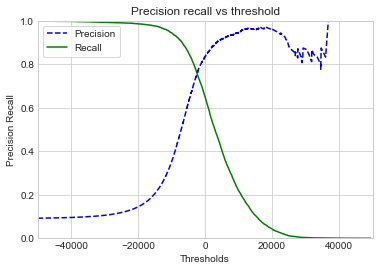

In [71]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)


plt.title("Precision recall vs threshold")
plt.xlabel("Thresholds")
plt.ylabel("Precision Recall")
plt.axis([-50000,50000,0,1])
plt.legend(frameon=True)
plt.show()


<strong>Side note:</strong> The precision curve is bumpy because it may reduce when we raise the threshold. However, precision surely goes down when the threshold is increased hence the smooth curve.

Say i would like my model to have 90% precision. I will need to know the lowest threshold i can use to achieve 90% precision.

To do this, use the <code>np.argmax()</code> function.

In [74]:
threshold_for_90prec = thresholds[np.argmax(precisions >=0.9)]

print(threshold_for_90prec)

3370.0194991439557


Now that we have our threshold, let us make predictions with it.

In [82]:
from sklearn.metrics import recall_score,precision_score

y_train_pred_90prec = (y_scores >= threshold_for_90prec)

#print the precision and recall for these predictions.




print(f'Recall: {recall_score(y_train_5,y_train_pred_90prec)} \nPrecision: {precision_score(y_train_5,y_train_pred_90prec)}')



Recall: 0.4799852425751706 
Precision: 0.9000345901072293


Now we can create a classifier with any amount of precision we want. However, the model will not be helpful if the recall is too low. that is, if is goind to miss a large portion of the positive values. 

Thus the answer to high precision is what cost for precision?

### The ROC curve 

The official name for the curve is the receiver operating characteristic. 

The ROC curve plots the true positive rate (recall) against the false positive rate.

The false positive rate is 1-(true negative rate)

The true negative rate is also called specificity. Thus, the roc curve plots sensitivity vs specificity

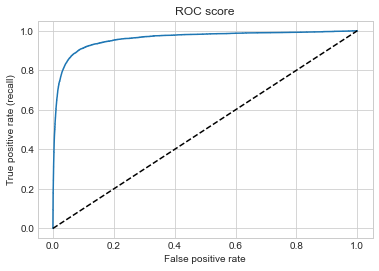

In [87]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    #plt.axis([0,1,0,1])

plot_roc_curve(fpr,tpr)
plt.title("ROC score")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (recall)")

plt.show()

Looking at the above graph, we see another tradeoff. The more the recall, the higher the false positive rate. 

The diagonal line represents a purely random classifier. Therefore, a good classifier stays as far as possible from the diagonal line.

we can confirm how good a classifier is by measuring its Area under curve, also called the ROC-AUC score. 



In [88]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_train_5,y_scores)

print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9604938554008616


A perfect model has a AUC ROC score of 1. 

Let us try the same process with a <code>RandomForestRegressor()</code>

Sklearn classifiers usually have a decision function or a prediction probability function.

the prediction probability function returns the probability that the prediction belongs to a certain class. 